In [1]:
import numpy as np
from scipy.interpolate import CubicSpline
from particle.literals import tau_minus
import pandas as pd
from particle import width_to_lifetime, lifetime_to_width # MeV <-> ns
import matplotlib.pyplot as plt

mtau = tau_minus.mass # MeV
fa = 1e6 # MeV
speed_light = 29.98 # cm/ns
a_em = 1/137
Gamma0 = lifetime_to_width(1/speed_light)
hbar = lifetime_to_width(1)/1000 # GeV ns
plt.rcParams['text.usetex'] = True

In [2]:
def f(x):
    if x >= 1:
        return np.arcsin(x**-0.5)
    else:
        return np.pi/2+0.5j*np.log((1+(1-x)**0.5)/(1-(1-x)**0.5))
B1 = lambda x: 1-x*f(x)**2

def Gamma_photons(ma):
    return a_em**2*ma**3/(fa**2*(4*np.pi)**3)*abs(B1(4*mtau**2/ma**2))**2

In [60]:
def coupling_length_ALP(length, ma, boosted=True):
    s=10.58**2
    mtau0 = mtau/1000
    if boosted:
        boost = np.sqrt(((s+ma**2)/(2*np.sqrt(s)*ma))**2-1)
    else:
        boost = 1
    return np.sqrt((4*np.pi)**3*mtau0**2*hbar*speed_light/(a_em**2*np.abs(B1(4*mtau0**2/ma**2))**2* ma**3*length)*boost)/(mtau*1e-6)

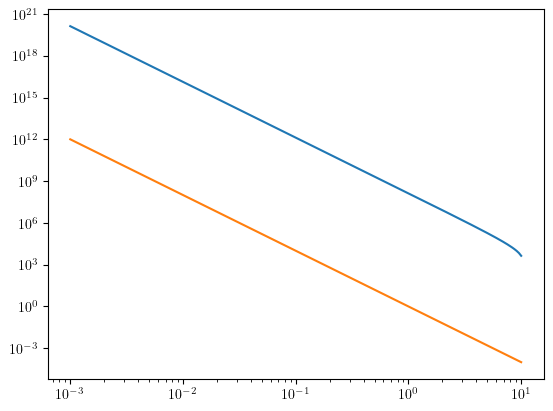

In [108]:
boost = lambda ma: np.sqrt(((10.58**2+ma**2)/(2*10.58*ma))**2-1)
propertau = lambda ma: np.sqrt((4*np.pi)**3*mtau**2*hbar*speed_light/(a_em**2*np.abs(B1(4*mtau**2/ma**2))**2* ma**3)*boost(ma))
plt.loglog(np.logspace(-3, 1, 200), [propertau(ma) for ma in np.logspace(-3, 1, 200)])
plt.loglog(np.logspace(-3, 1, 200), [ma**(-4) for ma in np.logspace(-3, 1, 200)])

## $e^+e^-\to\tau^+\tau^-\gamma\gamma$

In [4]:
df_taugamma20fb = pd.read_csv("tautaugammagamma_20fbinv.csv")
df_taugamma50ab = pd.read_csv("tautaugammagamma_50abinv.csv")

Text(0, 0.5, '$|c_\\tau|/f_a$')

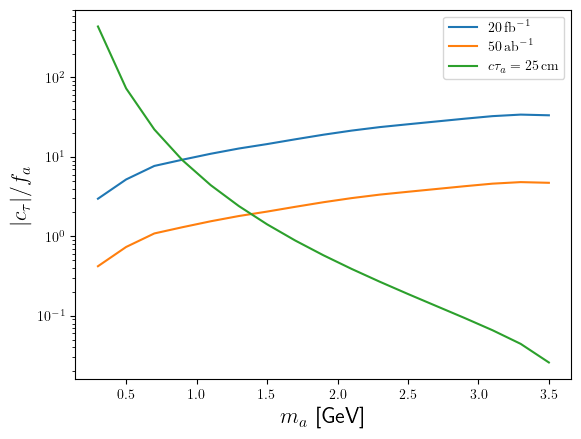

In [5]:
plt.semilogy(df_taugamma20fb['ma_GeV'], df_taugamma20fb['ctau'], label=r'$20\,\mathrm{fb}^{-1}$')
plt.semilogy(df_taugamma50ab['ma_GeV'], df_taugamma50ab['ctau'], label=r'$50\,\mathrm{ab}^{-1}$')
plt.semilogy(df_taugamma20fb['ma_GeV'], [coupling_length_ALP(25, ma, False) for ma in df_taugamma20fb['ma_GeV']], label=r'$c\tau_a = 25\,\mathrm{cm}$')
plt.legend()
plt.xlabel(r'$m_a$ [GeV]', fontsize=16)
plt.ylabel(r'$|c_\tau|/f_a$', fontsize=16)

In [6]:
interp_taugamma_20fb = CubicSpline(df_taugamma20fb['ma_GeV'], df_taugamma20fb['ctau'])
interp_taugamma_50ab = CubicSpline(df_taugamma50ab['ma_GeV'], df_taugamma50ab['ctau'])

In [7]:
bound_taugamma20fb = []
bound_taugamma50ab =[]
for ma in np.linspace(min(df_taugamma20fb['ma_GeV']), max(df_taugamma20fb['ma_GeV']), 200):
    lim_lifetime = coupling_length_ALP(25, ma, False)
    lim_exp20fb = interp_taugamma_20fb(ma)
    lim_exp50ab = interp_taugamma_50ab(ma)
    bound_taugamma20fb.append(max(lim_lifetime, lim_exp20fb))
    bound_taugamma50ab.append(max(lim_lifetime, lim_exp50ab))

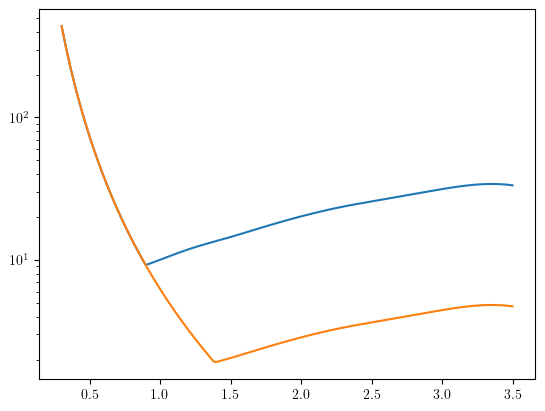

In [8]:
plt.semilogy(np.linspace(min(df_taugamma20fb['ma_GeV']), max(df_taugamma20fb['ma_GeV']), 200), bound_taugamma20fb)
plt.semilogy(np.linspace(min(df_taugamma20fb['ma_GeV']), max(df_taugamma20fb['ma_GeV']), 200), bound_taugamma50ab)

In [9]:
pd.DataFrame({'ma_GeV': np.linspace(min(df_taugamma20fb['ma_GeV']), max(df_taugamma20fb['ma_GeV']), 200), 'ctau_20fb-1': bound_taugamma20fb, 'ctau_50ab-1': bound_taugamma50ab}).to_csv('../data/direct_searches/tautaugammagamma.csv')

## Regions of the parameter space for $e^+e^-\to\gamma a$

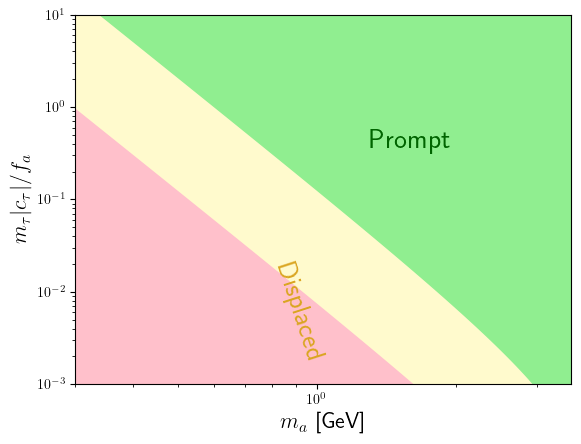

In [65]:
plt.fill_between(np.logspace(-4, np.log10(0.15), 200), [coupling_length_ALP(1, ma)*mtau*1e-6 for ma in np.logspace(-4, np.log10(0.15), 200)], 1e3, color='paleturquoise')
plt.fill_between(np.logspace(-3, 1, 200), [coupling_length_ALP(300, ma)*mtau*1e-6 for ma in np.logspace(-3, 1, 200)], [coupling_length_ALP(1, ma)*mtau*1e-6 for ma in np.logspace(-3, 1, 200)], color='lemonchiffon')
plt.fill_between(np.logspace(np.log10(0.15), 1, 200), [coupling_length_ALP(1, ma)*mtau*1e-6 for ma in np.logspace(np.log10(0.15), 1, 200)], 10, color='lightgreen')
plt.fill_between(np.logspace(-3, 1, 200), 0.1*mtau*1e-6, [coupling_length_ALP(300, ma)*mtau*1e-6 for ma in np.logspace(-3, 1, 200)], color='pink')
plt.ylim(1e-3, 10)
plt.xlim(0.3, 2e-3*mtau)
plt.annotate('Invisible', (4e-3, 3e-2), color='red', fontsize=20)
plt.annotate('Prompt', (1.3, 200*mtau*1e-6), color='darkgreen', fontsize=20)
plt.annotate('Displaced', (0.8, 1*mtau*1e-6), color='goldenrod', fontsize=20, rotation=-72)
plt.xlabel(r'$m_a$ [GeV]', fontsize=16)
plt.ylabel(r'$m_\tau|c_\tau|/f_a$', fontsize=16)
plt.annotate(r'$c_{\gamma\gamma}^0=0$', (1.5e-3, 2e-3), fontsize=14)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

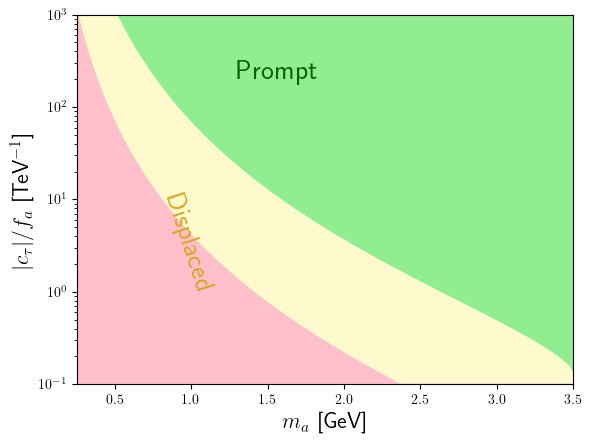

In [66]:
plt.fill_between(np.logspace(-4, np.log10(0.15), 200), [coupling_length_ALP(1, ma) for ma in np.logspace(-4, np.log10(0.15), 200)], 1e3, color='paleturquoise')
plt.fill_between(np.logspace(-3, 1, 200), [coupling_length_ALP(300, ma) for ma in np.logspace(-3, 1, 200)], [coupling_length_ALP(1, ma) for ma in np.logspace(-3, 1, 200)], color='lemonchiffon')
plt.fill_between(np.logspace(np.log10(0.15), 1, 200), [coupling_length_ALP(1, ma) for ma in np.logspace(np.log10(0.15), 1, 200)], 1e3, color='lightgreen')
plt.fill_between(np.logspace(-3, 1, 200), 0.1, [coupling_length_ALP(300, ma) for ma in np.logspace(-3, 1, 200)], color='pink')
plt.ylim(0.1, 1e3)
plt.xlim(0.25, 3.5)
plt.annotate('Invisible', (4e-3, 3), color='red', fontsize=20)
plt.annotate('Prompt', (1.3, 200), color='darkgreen', fontsize=20)
plt.annotate('Displaced', (0.8, 1), color='goldenrod', fontsize=20, rotation=-72)
plt.xlabel(r'$m_a$ [GeV]', fontsize=16)
plt.ylabel(r'$|c_\tau|/f_a$ [TeV$^{-1}$]', fontsize=16)
plt.annotate(r'$c_{\gamma\gamma}^0=0$', (1.5e-3, 1.8e-1), fontsize=14)
ax = plt.gca()
#ax.set_xscale('log')
ax.set_yscale('log')

## $e^+e^-\to 3\gamma$

In [10]:
df_3gamma_20fb = pd.read_csv('3gamma_20fb.csv')
df_3gamma_50ab = pd.read_csv('3gamma_50ab.csv')

(0.1, 100000.0)

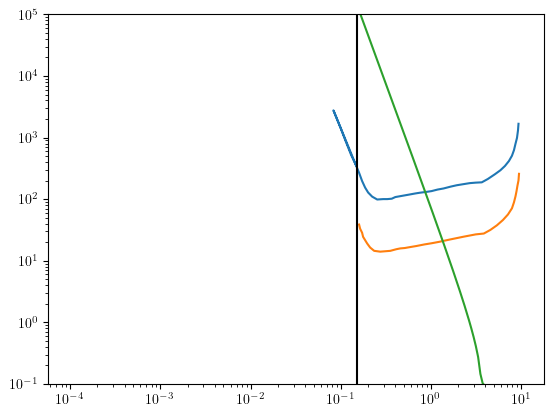

In [11]:
plt.loglog(df_3gamma_20fb['ma_GeV'], df_3gamma_20fb['gtau']/(mtau*1e-6))
plt.loglog(df_3gamma_50ab['ma_GeV'], df_3gamma_50ab['gtau']/(mtau*1e-6))
plt.loglog(np.logspace(-4, 1, 200), [coupling_length_ALP(1, ma) for ma in np.logspace(-4, 1, 200)])
plt.axvline(0.15, c='k')
plt.ylim(1e-1, 1e5)

In [12]:
ctau_3gamma_20fb = []
for i, ma in enumerate(df_3gamma_20fb.sort_values(by='ma_GeV')['ma_GeV']):
    ctau_3gamma_20fb.append(max(coupling_length_ALP(1, ma), df_3gamma_20fb['gtau'][i]/(mtau*1e-6)))

ctau_3gamma_50ab = []
for i, ma in enumerate(df_3gamma_50ab.sort_values(by='ma_GeV')['ma_GeV']):
    ctau_3gamma_50ab.append(max(coupling_length_ALP(1, ma), df_3gamma_50ab['gtau'][i]/(mtau*1e-6)))

In [13]:
interp_3gamma_20fb = CubicSpline(df_3gamma_20fb.sort_values(by='ma_GeV')['ma_GeV'], ctau_3gamma_20fb)
interp_3gamma_50ab = CubicSpline(df_3gamma_50ab.sort_values(by='ma_GeV')['ma_GeV'], ctau_3gamma_50ab)

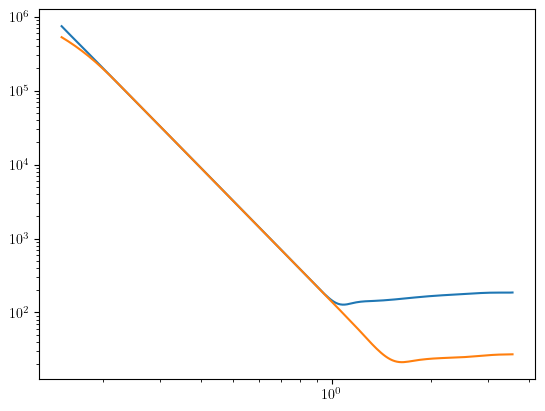

In [14]:
#plt.scatter(df_3gamma_20fb.sort_values(by='ma_GeV')['ma_GeV'], ctau_3gamma_20fb)
plt.plot(np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200), [interp_3gamma_20fb(ma) for ma in np.logspace(-1, np.log10(2e-3*mtau), 200)])
plt.plot(np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200), [interp_3gamma_50ab(ma) for ma in np.logspace(-1, np.log10(2e-3*mtau), 200)])
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

In [15]:
pd.DataFrame({
    'ma_GeV': np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200),
    'ctau_20fb-1': [interp_3gamma_20fb(ma) for ma in np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200)],
    'ctau_50ab-1': [interp_3gamma_20fb(ma) for ma in np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200)[:60]] + [interp_3gamma_50ab(ma) for ma in np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200)[60:]]
}).to_csv('../data/direct_searches/ee3gamma.csv', index=False)

## $e^+e^-\to \gamma +$ inv

In [16]:
df_gammainv_20fb = pd.read_csv('gammainv_20fb.csv')
df_gammainv_50ab = pd.read_csv('gammainv_50ab.csv')

(0.1, 100000.0)

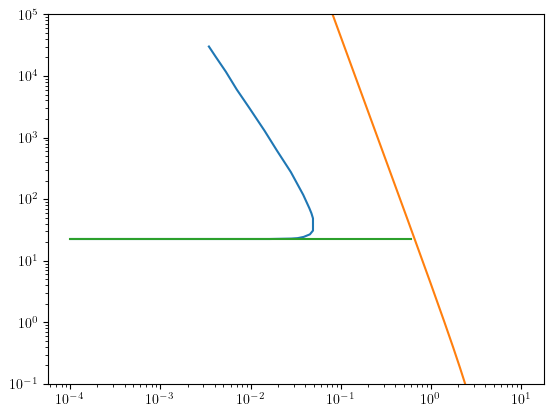

In [17]:
plt.loglog(df_gammainv_20fb['ma_GeV'], df_gammainv_20fb['gtau']/(mtau*1e-6))
plt.loglog(np.logspace(-4, 1, 200), [coupling_length_ALP(300, ma) for ma in np.logspace(-4, 1, 200)])
plt.plot([1e-4, 0.6], [df_gammainv_20fb['gtau'][0]/(mtau*1e-6), df_gammainv_20fb['gtau'][0]/(mtau*1e-6)])
plt.ylim(1e-1, 1e5)

(0.1, 100000.0)

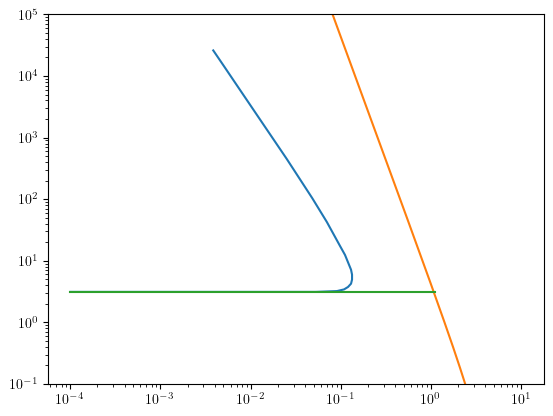

In [18]:
plt.loglog(df_gammainv_50ab['ma_GeV'], df_gammainv_50ab['gtau']/(mtau*1e-6))
plt.loglog(np.logspace(-4, 1, 200), [coupling_length_ALP(300, ma) for ma in np.logspace(-4, 1, 200)])
plt.plot([1e-4, 1.1], [df_gammainv_50ab['gtau'][0]/(mtau*1e-6), df_gammainv_50ab['gtau'][0]/(mtau*1e-6)])
plt.ylim(1e-1, 1e5)

In [19]:
low_gammainv_20fb = [df_gammainv_20fb['gtau'][0]/(mtau*1e-6) if ma<0.65 else np.nan for ma in np.logspace(-4, np.log10(1.1), 200)]

(0.001, 10)

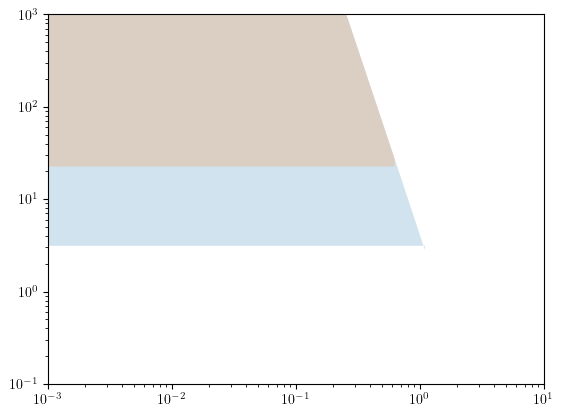

In [20]:

plt.fill_between(np.logspace(-4, np.log10(1.1), 200), df_gammainv_50ab['gtau'][0]/(mtau*1e-6), [coupling_length_ALP(300, ma) for ma in np.logspace(-4, np.log10(1.1), 200)], alpha=0.2)
plt.fill_between(np.logspace(-4, np.log10(1.1), 200), low_gammainv_20fb, [coupling_length_ALP(300, ma) for ma in np.logspace(-4, np.log10(1.1), 200)], alpha=0.2)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(0.1, 1000)
plt.xlim(1e-3, 10)

In [21]:
pd.DataFrame({
    'ma_GeV': np.logspace(-4, np.log10(1.1), 200),
    'ctau_20fb-1': low_gammainv_20fb,
    'ctau_50ab-1': [df_gammainv_50ab['gtau'][0]/(mtau*1e-6)]*200,
    'ctau_3m': [coupling_length_ALP(300, ma) for ma in np.logspace(-4, np.log10(1.1), 200)]
}).to_csv('../data/direct_searches/gammainv.csv')

## Final Plot

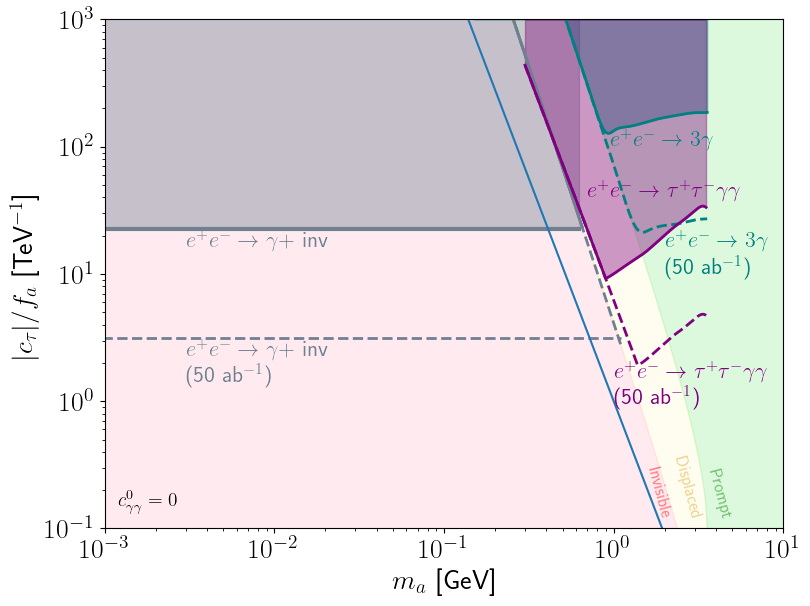

In [102]:
def erange(start, end):
    for i in range(start, end):
        if i ==0 :
            yield '$1$'
        elif i == 1:
            yield '$10$'
        else:
            yield r'$10^{'+str(i)+'}$'

fig = plt.figure(figsize=(8, 6))
plt.fill_between(np.logspace(-3, 1, 200), [coupling_length_ALP(300, ma) for ma in np.logspace(-3, 1, 200)], [coupling_length_ALP(1, ma) for ma in np.logspace(-3, 1, 200)], color='lemonchiffon', alpha=0.3)
plt.fill_between(np.logspace(np.log10(0.15), 1, 200), [coupling_length_ALP(1, ma) for ma in np.logspace(np.log10(0.15), 1, 200)], 1e3, color='lightgreen', alpha=0.3)
plt.fill_between(np.logspace(-3, 1, 200), 0.1, [coupling_length_ALP(300, ma) for ma in np.logspace(-3, 1, 200)], color='pink', alpha=0.3)
plt.annotate('Invisible', (1.54, 0.12), color='red', fontsize=12, alpha=0.5, rotation=-75)
plt.annotate('Displaced', (2.2, 0.12), color='goldenrod', fontsize=12, rotation=-75, alpha=0.5)
plt.annotate('Prompt', (3.5, 0.12), color='green', fontsize=12, alpha=0.5, rotation=-75)

plt.fill_between(np.logspace(-4, np.log10(1.1), 200), low_gammainv_20fb, [coupling_length_ALP(300, ma) for ma in np.logspace(-4, np.log10(0.21), 200)], alpha=0.4, color='slategray')
plt.loglog(np.logspace(-4, np.log10(1.1), 200), low_gammainv_20fb, c='slategray', lw=3)
plt.loglog(np.logspace(-4, np.log10(0.65), 200), [coupling_length_ALP(300, ma) for ma in np.logspace(-4, np.log10(0.65), 200)], c='slategray', lw=2)
plt.loglog([1e-4, 1.1], [df_gammainv_50ab['gtau'][0]/(mtau*1e-6), df_gammainv_50ab['gtau'][0]/(mtau*1e-6)], c='slategray', lw=2, ls='dashed')
plt.loglog(np.logspace(-4, np.log10(0.65), 200), [coupling_length_ALP(300, ma) for ma in np.logspace(-4, np.log10(0.65), 200)], c='slategray', lw=2)
plt.loglog(np.logspace(-4, np.log10(1.1), 200), [coupling_length_ALP(300, ma) for ma in np.logspace(-4, np.log10(1.1), 200)], c='slategray', lw=2, ls='dashed')
plt.annotate(r'$e^+e^-\to\gamma +$ inv', (3e-3, 16), color='slategray', fontsize=16)
plt.annotate(r'$e^+e^-\to\gamma +$ inv' + '\n' + r'(50 ab$^{-1}$)', (3e-3, 1.4), color='slategray', fontsize=16)

plt.fill_between(np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200), [interp_3gamma_20fb(ma) for ma in np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200)], 1e3, alpha=0.4, color='teal')
plt.loglog(np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200), [interp_3gamma_20fb(ma) for ma in np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200)], color='teal', lw=2)
plt.loglog(np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200), [interp_3gamma_50ab(ma) for ma in np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200)], color='teal', lw=2, ls='dashed')
plt.annotate(r'$e^+e^-\to 3\gamma$', (0.95, 100), color='teal', fontsize=16)
plt.annotate(r'$e^+e^-\to 3\gamma$' + '\n' + r'(50 ab$^{-1}$)', (2, 10), color='teal', fontsize=16)

plt.fill_between(np.linspace(min(df_taugamma20fb['ma_GeV']), max(df_taugamma20fb['ma_GeV']), 200), bound_taugamma20fb, 1e3,label=r'$20\,\mathrm{fb}^{-1}$', alpha=0.4, color='purple')
plt.loglog(np.linspace(min(df_taugamma20fb['ma_GeV']), max(df_taugamma20fb['ma_GeV']), 200), bound_taugamma20fb, color='purple', lw=2)
plt.loglog(np.linspace(min(df_taugamma20fb['ma_GeV']), max(df_taugamma20fb['ma_GeV']), 200), bound_taugamma50ab, color='purple', lw=2, ls='dashed')
plt.annotate(r'$e^+e^-\to \tau^+\tau^-\gamma\gamma$', (0.7, 40), color='purple', fontsize=16)
plt.annotate(r'$e^+e^-\to \tau^+\tau^-\gamma\gamma$' + '\n' + r'(50 ab$^{-1}$)', (1, 0.95), color='purple', fontsize=16)

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(0.1, 1000)
plt.xlim(1e-3, 10)
plt.xlabel(r'$m_a$ [GeV]', fontsize=20)
plt.ylabel(r'$|c_\tau|/f_a$ [TeV$^{-1}$]', fontsize=20)

plt.xticks([10**x for x in range(int(np.log10(1e-3)), 1+int(np.log10(10)))], labels=erange(int(np.log10(1e-3)), 1+int(np.log10(10))), fontsize=20)
plt.yticks([10**x for x in range(int(np.log10(1e-1)), 1+int(np.log10(1e3)))], labels=erange(int(np.log10(1e-1)), 1+int(np.log10(1e3))),fontsize=20)

plt.annotate(r'$c_{\gamma\gamma}^0 = 0$', (1.2e-3, 0.15), fontsize= 14)
plt.tight_layout(pad=0.5)
plt.loglog(np.logspace(-3, 1, 200), [ma**(-3.5) for ma in np.logspace(-3, 1, 200)])
#plt.savefig('BelleII_tau.pdf')